# 4 Systems of Differential Equations

In this tutorial, we apply the methods from the last tutorial to systems of first-order differential equations. We will also transform higher-order differential equations into systems of first-order equations, and analyse them as such.

In [17]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rc
rc("text", usetex=True) # Latex font in figures

### Two goods model

Consider the model in Tutorial 4, exercise 1:

$\begin{align}p_1' &= -2p_1 + 4p_2\\p_2' &= -p_1 + p_2\end{align}$

Or in vector notation:

$
    \left(\begin{matrix}
    p_1' \\ p_2'
    \end{matrix}\right) = \left(\begin{matrix} 
    -2 & 4 \\ -1 & 1
    \end{matrix}\right) \left(\begin{matrix}
    p_1 \\p_2
    \end{matrix}\right)
\Leftrightarrow 
    \mathbf{p}' = \mathbf{Ap}
$ 

We are going to implement one step of the explicit and implicit Euler schemes, as well as the Crank-Nicolson scheme in the functions below. Recall their implementations:

#### Explicit Euler
(In vector notation:)

$\mathbf{p}_{t+\delta} = \mathbf{p}_t + \delta\mathbf{p}'_{t}$

Which can be implement using the definition of the vector of derivatives above:

$\Rightarrow \mathbf{p}_{t+\delta} = \mathbf{p}_t + \delta\mathbf{Ap}_{t}$

#### Implicit Euler
$\mathbf{p}_{t+\delta} = \mathbf{p}_t + \delta\mathbf{p}'_{t+\delta} = \mathbf{p}_t + \delta\mathbf{Ap}_{t+\delta}$

This requires a finding the solution to a fixed-point problem, i.e. we have to solve for $\mathbf{p}_{t+\delta}$:

$\begin{align}
    \mathbf{p}_{t+\delta}(\mathbf{I} - \delta\mathbf{A}) &= \mathbf{p}_t \\
    \mathbf{p}_{t+\delta} &= (\mathbf{I} - \delta\mathbf{A})^{-1}\mathbf{p}_t
\end{align}$

Where $\mathbf{I}$ is the identity matrix.

#### Crank-Nicolson
$\begin{align}
    \mathbf{p}_{t+\delta} &= \mathbf{p}_t + \frac{\delta}{2}(\mathbf{p}'_{t+\delta} + \mathbf{p}'_{t}) = (\mathbf{I} + \frac{\delta}{2}\mathbf{A})\mathbf{p}_t + \frac{\delta}{2}\mathbf{A}\mathbf{p}_{t+\delta}\\
    \Leftrightarrow
    \mathbf{p}_{t+\delta} &= (\mathbf{I}-\frac{\delta}{2}\mathbf{A})^{-1}(\mathbf{I}+\frac{\delta}{2}\mathbf{A})\mathbf{p}_t
\end{align}$


##### Exercise
Implement each of these methods in the respective functions below. They should take as inputs the current price vector $p$, the coefficient matrix $A$, and the size of the step $\delta$. Invert matrices `M` with the `inv` function from numpy's subpackage linalg: `np.linalg.inv(M)`.

In [2]:
def ee_2goods(p, A, delta):
    # In this solution I factor out the price vector first and then perform the multiplication
    # Of course it is possible to achieve the correct results without this step
    mat = np.eye(2) + delta * A # for better readability, I create the matrix in a separate step
    return np.matmul(mat, p)

In [3]:
def ie_2goods(p, A, delta):
    # note that it would be computationally much more efficient to calculate this inverse once
    # and pass it into the single-step function when needed. To keep the use of all three functions
    # consistent (pass the coefficient matrix as input), we calculate it each time though
    M = np.eye(2) - delta*A
    M_inv = np.linalg.inv(M)
    return np.matmul(M_inv, p)

In [12]:
def cn_2goods(p, A, delta):
    # same logic applies as above, it would be more efficient to create the matrix M only once
    M1 = np.eye(2) - 0.5 * delta * A
    M1_inv = np.linalg.inv(M1)
    M2 = np.eye(2) + 0.5 * delta * A
    M = np.matmul(M1_inv, M2)
    return np.matmul(M, p)

##### Exercise
Implement the loop in the function below. The function simulates the behaviour of the model over time for 1 unit time step, which is divided into $1/\delta$ incremental time steps. The particular timestepping method is passed as an input as well, so later on we can exchange the methods flexibly and compare behaviour.

In [120]:
def simulate_2d_model(p, A, T, delta, timestep_func):
    '''
    This function simulates 2-dimensional dynamic models for T unit time steps.
    
    Inputs
        p            : initial value vector (numpy array length 2)
        A            : coefficient matrix (2x2 numpy array)
        T            : number of unit steps
        delta        : size of individual time steps (<<1)
        timestep_func: a function that implements one time step increment of size delta (ee, ie, cn)

    Output
        Time series array of values, starting with the initial values
    '''
    # number of time increments
    U = int(T / delta) # make sure it is an integer!
    
    results = np.empty((2, U+1))
    results[:,0] = p
    
    for u in range(U):
        p = timestep_func(p, A, delta)
        results[:,u+1] = p
        
    return results

Now we can simulate this model for a number of unit time steps and save the results to an array.

In [32]:
T = 10 # 10 unit time steps
delta = 1/512

p = np.array([2,2]) # initial price vector

A = np.array(
    [[-2, 4],
     [-1, 1]]
) # coefficient matrix

results = simulate_2d_model(p, A, T, delta, cn_2goods)

#### Plot the results

In the figure below, the results are plotted. In the left panel, you can see the time series of both prices, the right panel depicts the phase portrait.

For the phase protrait, we also have to calculate the isoclines:
    
$p_1'=0 \Leftrightarrow -2p_1 + 4 p_2 = 0 \Leftrightarrow p_2 = \frac{1}{2}p_1$

and

$p_2'=0 \Leftrightarrow -p_1 + p_2 = 0 \Leftrightarrow p_2 = p_1$

<IPython.core.display.Javascript object>


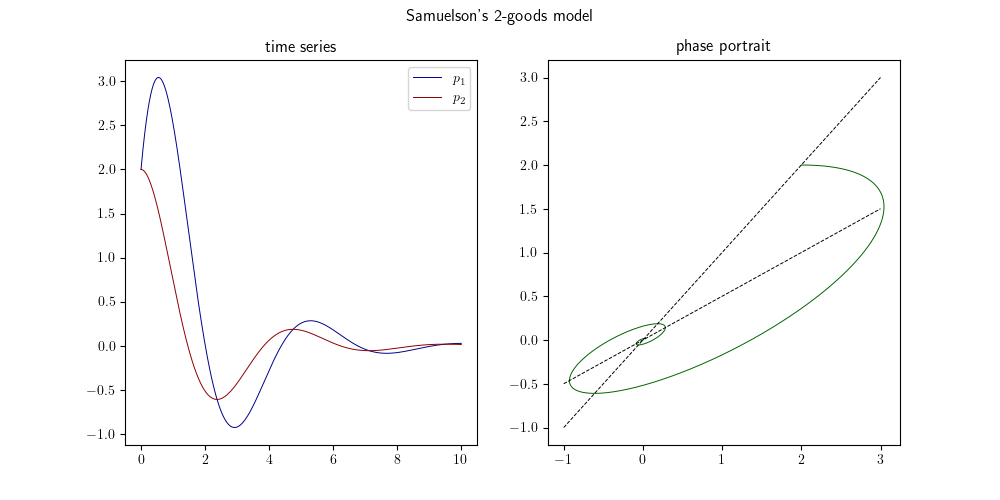

In [42]:
x_iso = np.array([-1, 3])

p1_iso = 0.5 * x_iso
p2_iso = x_iso


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

plt.suptitle("Samuelson's 2-goods model")
ax1.set_title("time series")
ax2.set_title("phase portrait")

x_ts = np.linspace(0, T, len(results[0]))

ax1.plot(x_ts, results[0], lw=0.7, c="darkblue", label="$p_1$")
ax1.plot(x_ts, results[1], lw=0.7, c="darkred", label="$p_2$")

ax1.legend()

ax2.plot(results[0], results[1], lw=0.7, c="darkgreen")
ax2.plot(x_iso, p1_iso, lw=0.7, c="black", ls='--')
ax2.plot(x_iso, p2_iso, lw=0.7, c="black", ls='--')

Find below the code for the solution figure for tutorial 4, exercise 1 b):

<IPython.core.display.Javascript object>


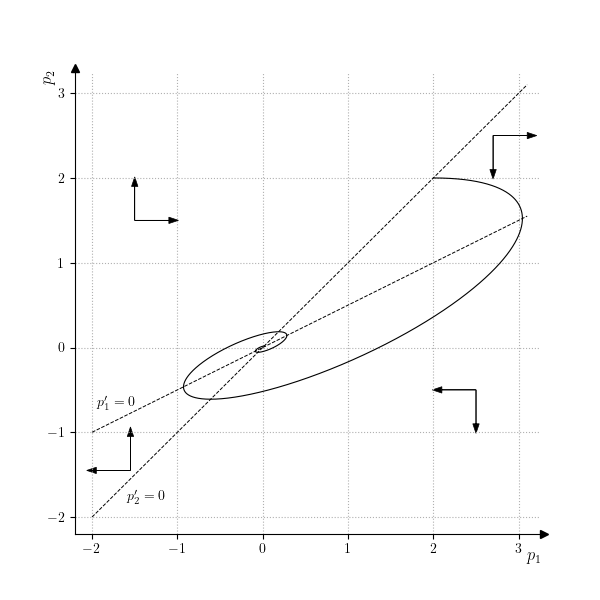

In [148]:
fig = plt.figure(figsize=(6,6))

# isoclines
x_iso = np.array([-2, 3.1])
p1_iso = 0.5 * x_iso
p2_iso = x_iso

# plot dynamics and isoclines
plt.plot(results[0], results[1], lw=0.8, c="black")
plt.plot(x_iso, p1_iso, lw=0.7, c="black", ls='--')
plt.plot(x_iso, p2_iso, lw=0.7, c="black", ls='--')

# isocline annotation
plt.text(-1.6, -1.8, "$p_2'=0$")
plt.text(-1.95, -0.7, "$p_1'=0$")

# axis labels
plt.xlabel("$p_1$", loc="right", labelpad=-5, fontsize=12)
plt.ylabel("$p_2$", loc="top", labelpad=-5, fontsize=12)

# hardcode the limits of the figure
plt.xlim(-2.2, 3.25)
plt.ylim(-2.2, 3.25)

# give the figure a more "mathy" feel by removing the top and left spines, 
# add arrowheads to the others
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.plot(3.3, 0, ">k", transform=ax.get_xaxis_transform(), clip_on=False)
ax.plot(0, 3.3, "^k", transform=ax.get_yaxis_transform(), clip_on=False)

##################################
## arrows of motion
# arrows take as input the starting point and the change in both dimension

# bottom right quadrant
plt.arrow(2.5, -0.5, -0.4, 0, lw=0.5, head_width=0.075, color='black')
plt.arrow(2.5, -0.5, 0, -0.4, lw=0.5, head_width=0.075, color='black')

# bottom left quadrant
plt.arrow(-1.55, -1.45, -0.4, 0, lw=0.5, head_width=0.075, color='black')
plt.arrow(-1.55, -1.45, 0, 0.4, lw=0.5, head_width=0.075, color='black')

# top left quadrant
plt.arrow(-1.5, 1.5, 0.4, 0, lw=0.5, head_width=0.075, color='black')
plt.arrow(-1.5, 1.5, 0, 0.4, lw=0.5, head_width=0.075, color='black')

# top right quadrant
plt.arrow(2.7, 2.5, 0.4, 0, lw=0.5, head_width=0.075, color='black')
plt.arrow(2.7, 2.5, 0, -0.4, lw=0.5, head_width=0.075, color='black')

# add a grid
plt.grid(linestyle=':')

# save the figure if you want to
#plt.savefig("samuelson2goods.png")

##### Exercise

Now consider the second-order differential equation $y'' + 2y = 0$. Instead of extending the methods we have learned to higher-order systems, re-state this equation as a 2-dimensional system of first-order differential equations and simulate it. You only have to define the coefficient matrix $A$, then we can re-use the single-step functions above. Finally, we will compare the three methods with this particular equation.

##### Solution

We define $z = y'$, so that we can write the equation as the following system:

$\begin{align}
    y' &= z\\
    y'' = z' &= -2y
\end{align}$

Or, in vector notation:

$
    \left(\begin{matrix}
    y' \\ z'
    \end{matrix}\right) = \left(\begin{matrix} 
    0 & 1 \\ -2 & 0
    \end{matrix}\right) \left(\begin{matrix}
    y \\ z
    \end{matrix}\right)
$

You can confirm that this system has purely imaginary eigenvalues $\lambda_{1,2} = \sqrt{2}i$. As the real part $Re(\lambda_{1,2})=0$, it is neither converging nor diverging, but remains on a stable cycle around the equilibrium, maintaining the same distance from it at all times.

In [136]:
A = np.array(
    [[0, 1], 
     [-2, 0]]
)

y0 = np.array([2,2])

T = 20
delta = 1/32

# we can apply the 2-goods model function, as the steps are exactly the same!
results_ee = simulate_2d_model(y0, A, T, delta, ee_2goods)
results_ie = simulate_2d_model(y0, A, T, delta, ie_2goods)
results_cn = simulate_2d_model(y0, A, T, delta, cn_2goods)

#### Accuracy comparison

See the phase diagram below for the motivation to prefer the Crank-Nicolson method over either of the two Euler schemes. We could show analytically that the system should stay in a stable limit cycle, orbiting the equilibrium. As the Euler schemes are first-order Taylor approximations of the "true" behaviour of the system, they create small errors, when second-order effects are present. Namely, in the case of a convex function ($\frac{\partial^2f}{\partial x^2}>0$), the explicit Euler scheme will create a positive bias, and the implicit Euler scheme a negative one. This can easily be proven with Jensen's inequality. The opposite holds for concave functions. Taking the mean of both will hence always provide much more accurate solutions! (Note: in physical applications, this is often related to the conservation of quantities such as energy.)

<IPython.core.display.Javascript object>


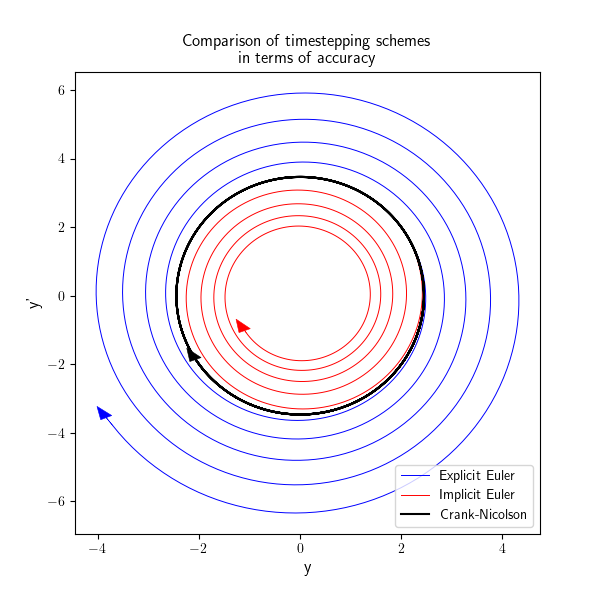

In [147]:
plt.figure(figsize=(6,6))
plt.title("Comparison of timestepping schemes\n in terms of accuracy")

plt.plot(results_ee[0], results_ee[1], c="blue", lw=0.7, label="Explicit Euler")
plt.plot(results_ie[0], results_ie[1], c="red", lw=0.7, label="Implicit Euler")
plt.plot(results_cn[0], results_cn[1], c="black", label="Crank-Nicolson")

# indicate direction using arrows on the last step
plt.arrow(
    results_ee[0, -1], 
    results_ee[1, -1], 
    results_ee[0, -1] - results_ee[0, -2], 
    results_ee[1, -1] - results_ee[1, -2],
    head_width=0.25, color="blue", lw=0.4)
plt.arrow(
    results_ie[0, -1], 
    results_ie[1, -1], 
    results_ie[0, -1] - results_ie[0, -2], 
    results_ie[1, -1] - results_ie[1, -2],
    head_width=0.25, color="red", lw=0.4)
plt.arrow(
    results_cn[0, -1], 
    results_cn[1, -1], 
    results_cn[0, -1] - results_cn[0, -2], 
    results_cn[1, -1] - results_cn[1, -2],
    head_width=0.25, color="black", lw=0.4)

plt.xlabel("y", fontsize=12)
plt.ylabel("y'", fontsize=12)

plt.legend()